In [79]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from yellowbrick.classifier import ConfusionMatrix 
from sklearn.metrics import average_precision_score , roc_auc_score
from sklearn import metrics
from skopt import forest_minimize
from lightgbm import LGBMClassifier

In [70]:
# Carregando os dados
df = pd.read_csv('train.csv').drop(['id','Vintage','Annual_Premium'],axis=1)
y_data = df['Response'].values


df = df.drop('Response',axis=1)
df.head(3)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel
0,Male,44,1,28.0,0,> 2 Years,Yes,26.0
1,Male,76,1,3.0,0,1-2 Year,No,26.0
2,Male,47,1,28.0,0,> 2 Years,Yes,26.0


In [71]:
# Transformando as variaveis categoricas para numericas
lb1 = LabelEncoder()
df['Gender']= lb1.fit_transform(df['Gender'])

lb2 = LabelEncoder()
df['Vehicle_Age']= lb2.fit_transform(df['Vehicle_Age'])

lb3 = LabelEncoder()
df['Vehicle_Damage']= lb3.fit_transform(df['Vehicle_Damage'])

In [72]:
# Divindo os dados entre treino e teste
x_train,x_test,y_train,y_test = train_test_split(df,
                                                y_data,test_size=0.3,
                                                random_state=0)

In [73]:
# Criando um modelo inicial,sem optimizações
lgbm = LGBMClassifier(random_state = 0,class_weight ='balanced',n_jobs=6)
lgbm.fit(x_train,y_train)

p_lg = lgbm.predict_proba(x_test)[:,1]
print(f'LGBMClassifier \nAVG: {average_precision_score(y_test,p_lg)} \nROC: {roc_auc_score(y_test,p_lg)}')

LGBMClassifier 
AVG: 0.3724581172835141 
ROC: 0.8586627006660189


In [74]:
# Criando uma função para meidr a proporçao de acertos
def acertos_prop(p,y):
    y = pd.Series(y)
    k,j = 0,0

    for e in range(len(y)):
        if (p[e] > 0.5 and y[e] == 0):
            k += 1
        
        elif (p[e] > 0.5 and y[e] == 1):
            j += 1
    prop = (j/(j+k))
    return prop

In [75]:
acertos_prop(p_lg,y_test)

0.28373814781140405

# Baysean Optmization

In [60]:
# Criando a função a ser utilizada na optimização
def tune_lgbm(params):
    print(params)
    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    
    
    
  
    mdl = LGBMClassifier(learning_rate=lr, num_leaves= 2**max_depth, max_depth=max_depth,
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, bagging_freq = 1, n_estimators=n_estimators, 
                         random_state = 0, class_weight ='balanced',n_jobs=6)
   
    mdl.fit(x_train,y_train)
    
    pl = mdl.predict_proba(x_test)[:,1]
    
            
    
    def acertos_prop(p,y):
        y = pd.Series(y)
        k,j = 0,0
        pl = p
        for e in range(len(y)):
            if (pl[e] > 0.5 and y[e] == 0):
                k += 1
        
            elif (pl[e] > 0.5 and y[e] == 1):
                j += 1
        prop = (j/(j+k))
        return prop
    
    print(average_precision_score(y_test,pl))
    
    return -acertos_prop(pl,y_test)

In [61]:
# Definindo o espaço de variação dos hyperparametros
space = [(1e-3,1e-1,'log-uniform'), #lr
         (1,10),    # max_depth
         (1,10),    #min_child_samples
         (0.05,1.), #subsamples
         (0.05,1.), #colsample_bytree
         (100,1000)]#n_estimators 

In [ ]:
# Realizando o processo de busca pelos melhores hyperparametros
res = forest_minimize(tune_lgbm,space,random_state=160745,n_random_starts=20,n_calls=50,verbose=1)

In [64]:
# Salvando os melhores hyperparametros numa lista
best = res.x
best = [0.0947253998586499, 7, 2, 0.5235636153223084, 0.6728679300083596, 747]

[0.0947253998586499, 7, 2, 0.5235636153223084, 0.6728679300083596, 747]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


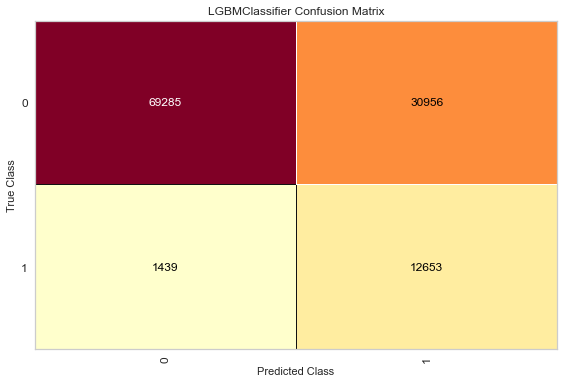

LGBMClassifier 
AVG: 0.36359401441376926 
ROC: 0.8537809328708842


In [77]:
# Criando um novo modelo utilizando os parametros encontrados 
lr = best[0]
max_depth = best[1]
min_child_samples = best[2]
subsample = best[3]
colsample_bytree = best[4]
n_estimators = best[5]


lgbm = ConfusionMatrix(LGBMClassifier(learning_rate=lr, num_leaves= 2**max_depth, max_depth=max_depth,
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, bagging_freq = 1, n_estimators=n_estimators, 
                         random_state = 0, class_weight ='balanced',n_jobs=6))

lgbm.fit(x_train,y_train)
lgbm.score(x_test, y_test)
lgbm.poof()

p_lg = lgbm.predict_proba(x_test)[:,1]
print(f'LGBMClassifier \nAVG: {average_precision_score(y_test,p_lg)} \nROC: {roc_auc_score(y_test,p_lg)}')

In [82]:
predicts = lgbm.predict(x_test)

print('Optmized LGBM Classifier') 
print(metrics.classification_report(y_test, predicts))

p_lg = lgbm.predict_proba(x_test)[:,1]
print(f'AUC: {roc_auc_score(y_test,p_lg)} \nAVG: {average_precision_score(y_test,p_lg)} ')

Optmized LGBM Classifier
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    100241
           1       0.29      0.90      0.44     14092

    accuracy                           0.72    114333
   macro avg       0.63      0.79      0.62    114333
weighted avg       0.89      0.72      0.76    114333

AUC: 0.8537809328708842 
AVG: 0.36359401441376926 
